# **Test Models**


This notebook evaluates the following pre-trained models on the test set:

- **Random Forest - Baseline**
- **Random Forest + CNN**
- **XGBoost**
- **Attention-based U-Net**
- **Hybrid SN**

**The results of each model are tested on the same test set and summarized in a final table for comparison.**


## 1. Setup

### 1.1 Install and Import Libraries

In [ ]:
!pip install \
    scipy \
    numpy \
    pandas \
    scikit-learn \
    tensorflow \
    matplotlib \
    joblib \
    scikit-image \
    opencv-python-headless \
    xgboost


import os
import pickle
import random
import gc
from multiprocessing import Pool
import joblib
import plotly.graph_objects as go

import cv2
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import numpy as np
import pandas as pd
import scipy.io
from google.colab import drive
from joblib import Parallel, delayed
from scipy.spatial.distance import euclidean
from skimage.transform import resize
from skimage.util import random_noise
from sklearn.decomposition import PCA
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import xgboost as xgb

### 1.2 Setting Seeds

In [ ]:
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

### 1.3 Connect to Google Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


### 1.4 Common Functions

In [ ]:
# Used in
# 2.Data Loading,
# 3.3 Remove Noise Channels
def flatten_data(images, labels):
    """
    Flatten the HSI images and labels.

    Parameters:
    - images (list): List of HSI images.
    - labels (list): List of HSI labels.

    Returns:
    - all_data (ndarray): Flattened HSI images.
    - all_labels (ndarray): Flattened HSI labels.
    """
    flattened_images = [image.reshape(-1, image.shape[-1]) for image in images]
    flattened_labels = [label.flatten() for label in labels]

    print("\nCombining flattened data...")
    all_data = np.vstack(flattened_images)
    all_labels = np.hstack(flattened_labels)

    print(f"\nFinal combined data shape: {all_data.shape}")
    print(f"Final combined labels shape: {all_labels.shape}")
    return all_data, all_labels

def evaluation_report(y_true_tiles, y_pred_tiles, y_proba_tiles, model_title):
    """
    Generate an evaluation report with overall metrics and print a table.

    Parameters:
    - y_true_tiles (array-like): True labels for each tile.
    - y_pred_tiles (array-like): Predicted labels for each tile.
    - y_proba_tiles (array-like): Predicted probabilities for each tile.
    - model_title (str): Title of the model for display purposes.
    """

    # Evaluate overall metrics
    overall_metrics = evaluate_overall(y_true_tiles, y_pred_tiles, y_proba_tiles)

    # Save overall_metrics to model_metrics under the model_title key
    model_metrics[model_title] = [
        overall_metrics["Accuracy"],
        overall_metrics["Precision"],
        overall_metrics["Recall"],
        overall_metrics["F1 Score"],
        overall_metrics["AUC"]
    ]

    # Create a DataFrame for the metrics table
    metrics_table = pd.DataFrame({
        "Metric": ["Accuracy", "Precision", "Recall", "F1 Score", "AUC"],
        "Value": [
            overall_metrics["Accuracy"],
            overall_metrics["Precision"],
            overall_metrics["Recall"],
            overall_metrics["F1 Score"],
            overall_metrics["AUC"]
        ]
    })

    # Print the metrics table
    print(f"Overall Metrics for {model_title} Model:")
    print(metrics_table.to_string(index=False))

    # Evaluate metrics per tile
    metrics_per_tile, zero_accuracy_tiles, low_recall_tiles, low_precision_tiles = evaluate_metrics_per_tile(
        y_true_tiles, y_pred_tiles
    )

    # Plot histograms with cumulative percentages
    plot_histograms_with_cumulative_percentage(metrics_per_tile)



def evaluate_overall(y_true_tiles, y_pred_tiles, y_proba_tiles):
    """
    Evaluate overall metrics: precision, recall, accuracy, F1 score, and AUC.
    """
    y_true = y_true_tiles.flatten()
    y_pred = y_pred_tiles.flatten()
    y_proba = y_proba_tiles.flatten()

    conf_matrix = confusion_matrix(y_true, y_pred)

    # Handle cases where the confusion matrix may not have all classes
    tp = conf_matrix[1, 1] if conf_matrix.shape == (2, 2) else 0
    tn = conf_matrix[0, 0] if conf_matrix.shape == (2, 2) else 0
    fp = conf_matrix[0, 1] if conf_matrix.shape == (2, 2) else 0
    fn = conf_matrix[1, 0] if conf_matrix.shape == (2, 2) else 0

    precision = tp / (tp + fp) if (tp + fp) > 0 else None
    recall = tp / (tp + fn) if (tp + fn) > 0 else None
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision and recall) else None
    auc = roc_auc_score(y_true, y_proba) if len(np.unique(y_true)) > 1 else None

    return {
        "Confusion Matrix": conf_matrix,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "F1 Score": f1_score,
        "AUC": auc,
    }


def flatten_tiles(images, labels):
    """
    Flatten image and label tiles into 2D and 1D arrays, respectively.
    """
    print("Flattening image and label tiles...")
    flattened_images = np.vstack([image.reshape(-1, image.shape[-1]) for image in images])
    flattened_labels = np.vstack([label.flatten() for label in labels])
    print(f"Flattened {len(images)} tiles.")
    return flattened_images, flattened_labels


#def flatten_tiles(images, labels):
#    """
#    Flatten image and label tiles into a 2D array and a 1D array, respectively.
#    """
#    flattened_images = [image.reshape(-1, image.shape[-1]) for image in images]
#    flattened_labels = [label.flatten() for label in labels]
#    return flattened_images, flattened_labels

def load_model(model_path):
    """
    Load a trained model from a file. Supports both scikit-learn and Keras models.

    Parameters:
    - model_path (str): Path to the model file.

    Returns:
    - model: Loaded model.
    """
    print(f"Loading model from {model_path}...")
    if model_path.endswith('.pkl'):
        model = joblib.load(model_path)
    elif model_path.endswith('.h5') or model_path.endswith('.keras'):
        model = tf.keras.models.load_model(model_path)
    else:
        raise ValueError("Unsupported model file format.")
    print("Model loaded successfully.")
    return model


def evaluate_metrics_per_tile(y_pred_tiles, test_labels):
    """
    Evaluate metrics per tile for a test set using a trained model.
    Handles tiles with only one class explicitly to ensure meaningful metrics.
    """
    metrics_per_tile = []
    zero_accuracy_tiles = []
    low_recall_tiles = []
    low_precision_tiles = []

    print("Evaluating metrics per tile...")
    for i, (y_pred_tile, y_test_tile) in enumerate(zip(y_pred_tiles, test_labels)):
        # Directly calculate TP, TN, FP, FN
        tp = np.sum((y_test_tile == 1) & (y_pred_tile == 1))  # True Positives
        tn = np.sum((y_test_tile == 0) & (y_pred_tile == 0))  # True Negatives
        fp = np.sum((y_test_tile == 0) & (y_pred_tile == 1))  # False Positives
        fn = np.sum((y_test_tile == 1) & (y_pred_tile == 0))  # False Negatives

        # Handle tiles with no positive ground truth (all water)
        if np.all(y_test_tile == 0):  # Only water
            precision = None  # Precision not defined
            recall = None  # Recall not defined
            f1_score_tile = None  # F1 Score not defined
        else:
            # Compute precision, recall, and F1 for mixed-class tiles
            precision = tp / (tp + fp) if (tp + fp) > 0 else None
            recall = tp / (tp + fn) if (tp + fn) > 0 else None
            if(recall is not None and precision is not None):
                if (precision > 0 and recall > 0):
                    f1_score_tile = (2 * (precision * recall) / (precision + recall))
                else:
                    f1_score_tile = 0
                f1_score_tile = (2 * (precision * recall) / (precision + recall))
            else:
                f1_score_tile= None

        # Accuracy calculation
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

        metrics = {
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "f1_score": f1_score_tile,
            "tp": tp,
            "tn": tn,
            "fp": fp,
            "fn": fn,
        }

        # Add to specific lists if thresholds are met
        if accuracy == 0:
            zero_accuracy_tiles.append(i)
        if recall is not None and recall < 0.5:  # Example threshold for recall
            low_recall_tiles.append(i)
        if precision is not None and precision < 0.5:  # Example threshold for precision
            low_precision_tiles.append(i)

        metrics_per_tile.append(metrics)
        print(
            f"Tile {i + 1}/{len(test_labels)}: "
            f"TP={tp}, TN={tn}, FP={fp}, FN={fn}, "
            f"Precision={precision}, Recall={recall}, Accuracy={accuracy:.4f}, "
            f"F1 Score={f1_score_tile}"
        )

    return metrics_per_tile, zero_accuracy_tiles, low_recall_tiles, low_precision_tiles


def predict_cnn_tiles(model, test_images, threshold=0.5):
    """
    Predict probabilities and labels for each tile using a CNN model.
    Handle cases where probabilities are extreme.
    """
    y_proba_tiles = np.array([
        model.predict(tile[np.newaxis, ...]).flatten()
        for tile in test_images
    ])
    y_pred_tiles = (y_proba_tiles > threshold).astype(int)

    # Debugging: Check for extreme values
    print(f"Prediction probabilities - Min: {np.min(y_proba_tiles)}, Max: {np.max(y_proba_tiles)}")
    print(f"Unique predicted labels: {np.unique(y_pred_tiles)}")

    return y_pred_tiles, y_proba_tiles

def visualize_label_maps(title,predicted_tiles_labels, test_tiles_labels, tiles_indices="all"):
    """
    Visualize problematic tiles with GT and predicted label maps.

    Parameters:
    - test_labels (list): List of test label tiles (H, W).
    - tiles_indices (list): List of tile indices to visualize.
    - title (str): Title for the visualization (e.g., "Zero Accuracy Tiles").
    """
    if tiles_indices=="all":
        tiles_indices = range(len(test_tiles_labels))

    print(f"Visualizing {len(tiles_indices)} {title.lower()}...")

    for idx in tiles_indices:
        # Get the ground truth label tile
        gt_label = test_tiles_labels[idx]
        pred_label = predicted_tiles_labels[idx]

        # Plot GT and Prediction side by side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(gt_label, cmap="viridis")
        axes[0].set_title("Ground Truth Label Map")
        axes[0].axis("off")

        axes[1].imshow(pred_label, cmap="viridis")
        axes[1].set_title("Predicted Label Map")
        axes[1].axis("off")

        plt.suptitle(f"{title} - Tile Index: {idx}", fontsize=14)
        plt.tight_layout()
        plt.show()




def plot_histograms_with_cumulative_percentage(metrics_per_tile):
    """
    Plot histograms and cumulative percentages for evaluation metrics across tiles,
    excluding None values from metrics.
    """
    print("Plotting histograms and cumulative percentages...")
    metrics = ["precision", "recall", "accuracy", "f1_score"]
    threshold = 0.7  # Threshold for metrics

    stability_metrics = {}

    # Extract valid values for each metric
    for metric in metrics:
        values = [m[metric] for m in metrics_per_tile if m[metric] is not None]
        stability_metrics[metric] = {
            "values": np.sort(values),  # Sorted for cumulative percentage
        }
        print(f"Metric: {metric}, Valid Values: {values}")

    # Plot histograms and cumulative percentages
    fig, axes = plt.subplots(2, 2, figsize=(12, 20))  # Wider than tall for rectangular plots
    fig.subplots_adjust(top=0.85, hspace=0.4)  # Leave more space at the top


    # Sample lines for legend - only one of each type needs to be added
    hist_sample = None
    threshold_sample = None
    cumulative_sample = None

    for idx, (metric, stats) in enumerate(stability_metrics.items()):
        ax1 = axes[idx // 2, idx % 2]
        ax2 = ax1.twinx()

        values = stats["values"]

        if len(values) == 0:  # Skip empty metrics
            print(f"Metric {metric} has no valid values. Skipping.")
            continue

        cumulative_percentage = np.arange(1, len(values) + 1) / len(values) * 100

        # Plot histogram
        if hist_sample is None:
            hist_sample = ax1.hist(values, bins=10, alpha=0.6, color="#3498db", edgecolor="black", label="Frequency")[2][0]  # Use the first bar for the legend
        else:
            ax1.hist(values, bins=10, alpha=0.6, color="#3498db", edgecolor="black")
        ax1.set_xlabel(metric.capitalize(), fontsize=20)
        ax1.set_ylabel("Frequency", color="#3498db", fontsize=20)
        ax1.tick_params(axis='y', labelcolor="#3498db")

        # Plot cumulative percentage
        if cumulative_sample is None:
            cumulative_sample, = ax2.plot(values, cumulative_percentage, color="#e74c3c", linestyle="-", marker=".")
        else:
            ax2.plot(values, cumulative_percentage, color="#e74c3c", linestyle="-", marker=".")
        ax2.set_ylabel("Cumulative Percentage", color="#e74c3c", fontsize=20, labelpad=15)  # Added padding
        ax2.tick_params(axis='y', labelcolor="#e74c3c")

        # Mark the threshold
        below_threshold = np.sum(values < threshold) / len(values) * 100

        # Contrasting color for threshold lines - using purple here for good contrast
        purple_color = "#2b00ff"

        # Vertical line at threshold, with purple color
        if threshold_sample is None:
            threshold_sample = ax1.axvline(x=threshold, color=purple_color, linestyle="--", linewidth=2)
        else:
            ax1.axvline(x=threshold, color=purple_color, linestyle="--", linewidth=2)
        ax1.text(threshold, -3, f'{threshold}',  # Positioned lower
                 color=purple_color, horizontalalignment='center', verticalalignment='top', weight='bold')

        # Horizontal line for cumulative percentage below threshold, with purple color
        ax2.axhline(y=below_threshold, color=purple_color, linestyle="--", linewidth=2)
        ax2.text(ax2.get_xlim()[1], below_threshold, f'{below_threshold:.2f}',
                 color=purple_color, horizontalalignment='left', verticalalignment='center', weight='bold')

        # Add a purple circle at the intersection on the correct axis (ax2)
        ax2.plot(threshold, below_threshold, 'o', color=purple_color, markersize=10, markeredgecolor=purple_color)

    # Create one legend for the entire plot
    fig.legend([hist_sample, threshold_sample, cumulative_sample],
               ['Frequency', 'Threshold', 'Cumulative Percentage'],
               loc='upper center', bbox_to_anchor=(0.5, 1.1),
               ncol=3, fontsize=20, frameon=False)

    plt.suptitle("Histograms and Cumulative Percentages of Metrics Across Tiles", fontsize=22)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the plot layout to make room for the legend
    plt.show()


def flat_prediction_to_tile_shape(flat_pred, test_labels):
    """
    Convert a flattened prediction back to the original tile shape.
    Handles predictions with multiple output dimensions (e.g., probabilities).
    """
    pred_tiles = []
    start_idx = 0

    for idx, label in enumerate(test_labels):
        original_shape = label.shape
        num_pixels = np.prod(original_shape)

        # Check if flat_pred has multiple dimensions (e.g., probabilities for two classes)
        if flat_pred.ndim > 1:
            # Take only the relevant column (e.g., class 1 probabilities)
            flat_pred = flat_pred[:, 1]

        # Ensure the segment size matches the expected number of pixels
        segment = flat_pred[start_idx:start_idx + num_pixels]
        if segment.size != num_pixels:
            raise ValueError(
                f"Mismatch: expected {num_pixels} pixels, got {segment.size} pixels."
            )

        # Reshape and append
        pred_tile = segment.reshape(original_shape)
        pred_tiles.append(pred_tile)
        start_idx += num_pixels

    return pred_tiles



model_metrics = {}

## 2. Load Processed Dataset

In [ ]:
import numpy as np

# Define the number of PCA components dynamically
n_components = 32  # Change this value as needed
base_save_path = "/content/drive/MyDrive/DataSets/HSI-Augmented-Splitted"

# Generate dynamic paths
save_paths = {
    "train_data": f"{base_save_path}/TrainTiles_{n_components}PCA_normalized.npz",
    "val_data": f"{base_save_path}/ValTiles_{n_components}PCA_normalized.npz",
    "test_data": f"{base_save_path}/TestTiles_{n_components}PCA_normalized.npz",
    "train_labels": f"{base_save_path}/TrainLabels_{n_components}PCA_normalized.npz",
    "val_labels": f"{base_save_path}/ValLabels_{n_components}PCA_normalized.npz",
    "test_labels": f"{base_save_path}/TestLabels_{n_components}PCA_normalized.npz",
    "test_masks": f"{base_save_path}/TestMasks_{n_components}PCA_normalized.npz"
}

def load_npz_as_list(file_path):
    """
    Load data from an .npz file and return a list of arrays.

    Parameters:
    - file_path (str): Path to the .npz file.

    Returns:
    - data_list (list): List of arrays from the .npz file.
    """
    print(f"Loading data from {file_path}...")
    data = np.load(file_path, allow_pickle=True)
    data_list = [data[key] for key in data.files]
    print(f"Loaded {len(data_list)} items from {file_path}")
    return data_list

# Load the data
train_images = load_npz_as_list(save_paths["train_data"])
val_images = load_npz_as_list(save_paths["val_data"])
test_images = load_npz_as_list(save_paths["test_data"])

train_labels = load_npz_as_list(save_paths["train_labels"])
val_labels = load_npz_as_list(save_paths["val_labels"])
test_labels = load_npz_as_list(save_paths["test_labels"])

# Load test masks
print(f"Loading test masks from {save_paths['test_masks']}...")
test_masks = np.load(save_paths["test_masks"], allow_pickle=True)['test_masks']
print(f"Loaded test masks with shape: {test_masks.shape}")

# Print shapes to verify
print("\nVerification:")
print(f"Loaded train_images: {len(train_images)} tiles")
print(f"Loaded val_images: {len(val_images)} tiles")
print(f"Loaded test_images: {len(test_images)} tiles")

print(f"Loaded train_labels: {len(train_labels)} labels")
print(f"Loaded val_labels: {len(val_labels)} labels")
print(f"Loaded test_labels: {len(test_labels)} labels")

Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TrainTiles_32PCA_normalized.npz...
Loaded 6804 items from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TrainTiles_32PCA_normalized.npz
Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/ValTiles_32PCA_normalized.npz...
Loaded 759 items from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/ValTiles_32PCA_normalized.npz
Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TestTiles_32PCA_normalized.npz...
Loaded 780 items from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TestTiles_32PCA_normalized.npz
Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TrainLabels_32PCA_normalized.npz...
Loaded 6804 items from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/TrainLabels_32PCA_normalized.npz
Loading data from /content/drive/MyDrive/DataSets/HSI-Augmented-Splitted/ValLabels_32PCA_normalized.npz...
Loaded 759 items from /cont

The following code prints the distribution of each label

In [ ]:
import numpy as np

def calculate_label_distribution(labels):
    """
    Calculate the percentage distribution of labels (0 and 1).

    Parameters:
    - labels (list of numpy arrays): List of label tiles.

    Returns:
    - dict: Dictionary with the percentage of each label.
    """
    # Flatten all label tiles into a single array
    all_labels = np.hstack([label.flatten() for label in labels])

    # Count occurrences of each label
    total_count = len(all_labels)
    water_count = np.sum(all_labels == 0)
    oil_count = np.sum(all_labels == 1)

    # Calculate percentages
    water_percentage = (water_count / total_count) * 100
    oil_percentage = (oil_count / total_count) * 100

    return {"Water (0)": water_percentage, "Oil (1)": oil_percentage}

# Calculate distributions
train_distribution = calculate_label_distribution(train_labels)
val_distribution = calculate_label_distribution(val_labels)
test_distribution = calculate_label_distribution(test_labels)

# Print results
print("Label Distribution in Training Set:", train_distribution)
print("Label Distribution in Validation Set:", val_distribution)
print("Label Distribution in Test Set:", test_distribution)

# Calculate overall distribution
all_labels = train_labels + val_labels + test_labels
overall_distribution = calculate_label_distribution(all_labels)
print("Label Distribution in Entire Dataset:", overall_distribution)

Label Distribution in Training Set: {'Water (0)': 90.07933637382422, 'Oil (1)': 9.920663626175779}
Label Distribution in Validation Set: {'Water (0)': 94.94239696557972, 'Oil (1)': 5.05760303442029}
Label Distribution in Test Set: {'Water (0)': 94.6806139823718, 'Oil (1)': 5.319386017628205}
Label Distribution in Entire Dataset: {'Water (0)': 90.95193130655939, 'Oil (1)': 9.048068693440609}


In [ ]:
gc.collect()

539

## 3. Random Forest - Baseline

In [ ]:
#  uncomment to LOAD the Random Forest model ------------------------------
rf = load_model("/content/drive/MyDrive/HSI MODELS/random_forest_ PCA 32 - Normalized.pkl")

Loading model from /content/drive/MyDrive/HSI MODELS/random_forest_ PCA 32 - Normalized.pkl...
Model loaded successfully.


Flattening testing data...
Flattening image and label tiles...
Flattened 780 tiles.
Flattened test images shape: (3194880, 32)
Overall Metrics for RF Model:
   Metric    Value
 Accuracy 0.980970
Precision 0.840941
   Recall 0.792078
 F1 Score 0.815778
      AUC 0.988566
Evaluating metrics per tile...
Tile 1/780: TP=396, TN=3209, FP=430, FN=61, Precision=0.4794188861985472, Recall=0.8665207877461707, Accuracy=0.8801, F1 Score=0.61730319563523
Tile 2/780: TP=0, TN=3903, FP=0, FN=193, Precision=None, Recall=0.0, Accuracy=0.9529, F1 Score=None
Tile 3/780: TP=77, TN=3921, FP=94, FN=4, Precision=0.4502923976608187, Recall=0.9506172839506173, Accuracy=0.9761, F1 Score=0.611111111111111
Tile 4/780: TP=242, TN=3766, FP=44, FN=44, Precision=0.8461538461538461, Recall=0.8461538461538461, Accuracy=0.9785, F1 Score=0.8461538461538461
Tile 5/780: TP=27, TN=4054, FP=11, FN=4, Precision=0.7105263157894737, Recall=0.8709677419354839, Accuracy=0.9963, F1 Score=0.782608695652174
Tile 6/780: TP=189, TN=38

<ipython-input-8-49e4eddd47bb>:180: RuntimeWarning: invalid value encountered in scalar divide
  f1_score_tile = (2 * (precision * recall) / (precision + recall))


Tile 620/780: TP=60, TN=4023, FP=9, FN=4, Precision=0.8695652173913043, Recall=0.9375, Accuracy=0.9968, F1 Score=0.9022556390977444
Tile 621/780: TP=0, TN=4096, FP=0, FN=0, Precision=None, Recall=None, Accuracy=1.0000, F1 Score=None
Tile 622/780: TP=14, TN=4057, FP=23, FN=2, Precision=0.3783783783783784, Recall=0.875, Accuracy=0.9939, F1 Score=0.5283018867924528
Tile 623/780: TP=0, TN=4096, FP=0, FN=0, Precision=None, Recall=None, Accuracy=1.0000, F1 Score=None
Tile 624/780: TP=1108, TN=2763, FP=128, FN=97, Precision=0.8964401294498382, Recall=0.9195020746887966, Accuracy=0.9451, F1 Score=0.9078246620237607
Tile 625/780: TP=41, TN=4001, FP=42, FN=12, Precision=0.4939759036144578, Recall=0.7735849056603774, Accuracy=0.9868, F1 Score=0.6029411764705882
Tile 626/780: TP=1738, TN=2126, FP=24, FN=208, Precision=0.9863791146424518, Recall=0.8931140801644398, Accuracy=0.9434, F1 Score=0.9374325782092772
Tile 627/780: TP=2573, TN=1327, FP=35, FN=161, Precision=0.986579754601227, Recall=0.94111

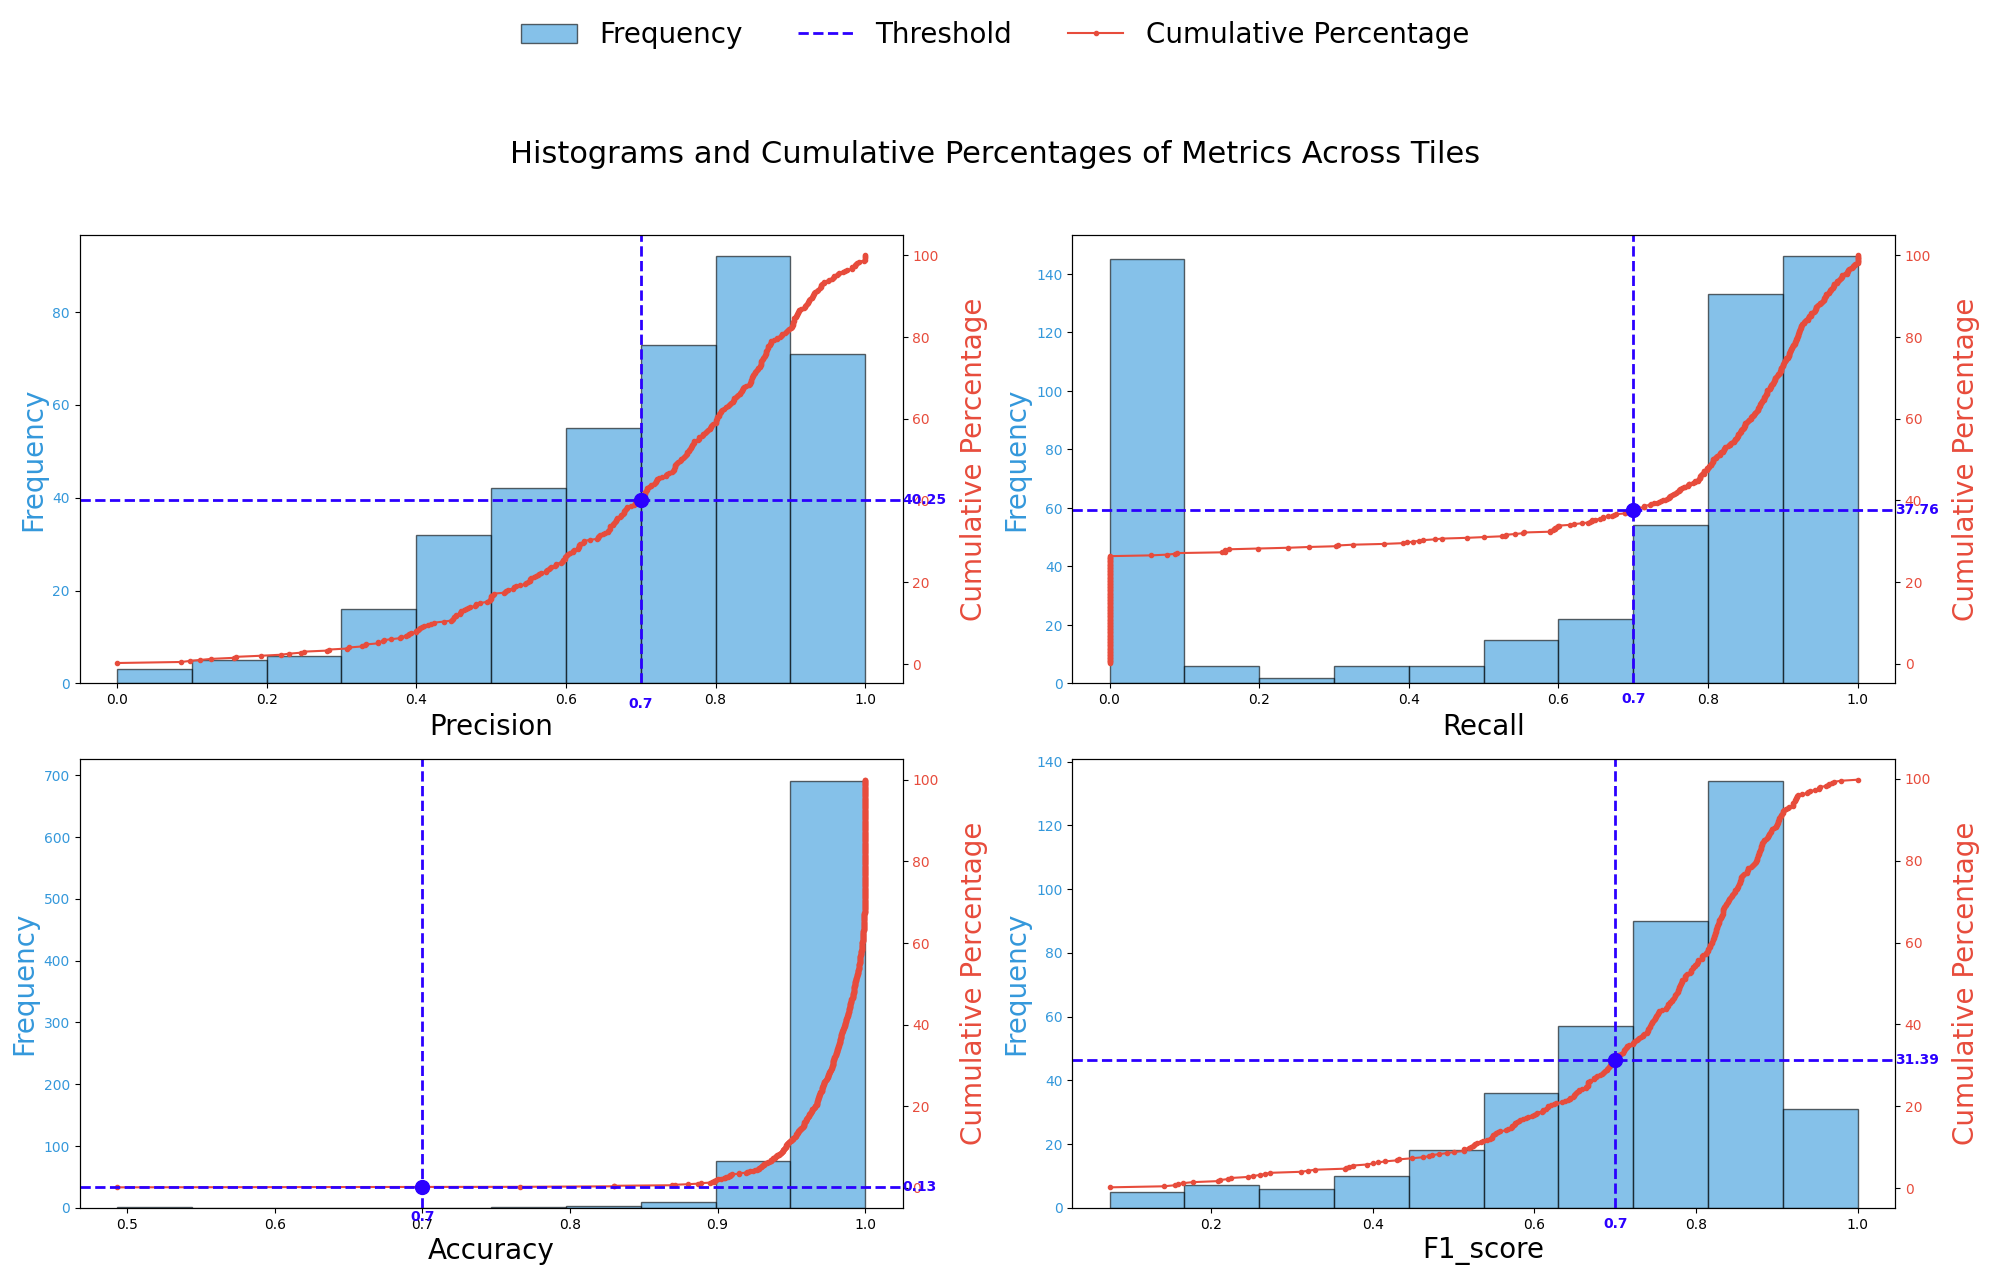

26804

In [ ]:
print("Flattening testing data...")

# Flatten the test images and labels
test_images_flattened, test_labels_flattened = flatten_tiles(test_images, test_labels)

# Ensure the flattened images are in the correct shape (n_samples, n_features)
test_images_flattened = test_images_flattened.reshape(
    test_images_flattened.shape[0], -1
)

print(f"Flattened test images shape: {test_images_flattened.shape}")

# Predict probabilities
predictions_proba = rf.predict_proba(test_images_flattened)

# Convert probabilities to binary labels
predictions_labels = (predictions_proba[:, 1] > 0.5).astype(int)

# Reshape predictions back to the original tile shape
reshaped_predictions_proba = flat_prediction_to_tile_shape(predictions_proba[:, 1], test_labels)
reshaped_predictions_labels = flat_prediction_to_tile_shape(predictions_labels, test_labels)

# Evaluate and report metrics
evaluation_report(np.array(test_labels), np.array(reshaped_predictions_labels), np.array(reshaped_predictions_proba), "RF")

gc.collect()

## 4. Random Forest + CNN

Loading CNN model  ...
Loading model from /content/drive/MyDrive/HSI MODELS/best_rf_cnn_model_normalized.keras...
Model loaded successfully.
CNN model loaded successfully.
Loading RF model from /content/drive/MyDrive/HSI MODELS/random_forest_ PCA 32 - Normalized.pkl...
RF model loaded successfully.
Flattening test and validation data...
Making predictions with RF...
Predictions reshaped successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

<ipython-input-8-49e4eddd47bb>:180: RuntimeWarning: invalid value encountered in scalar divide
  f1_score_tile = (2 * (precision * recall) / (precision + recall))


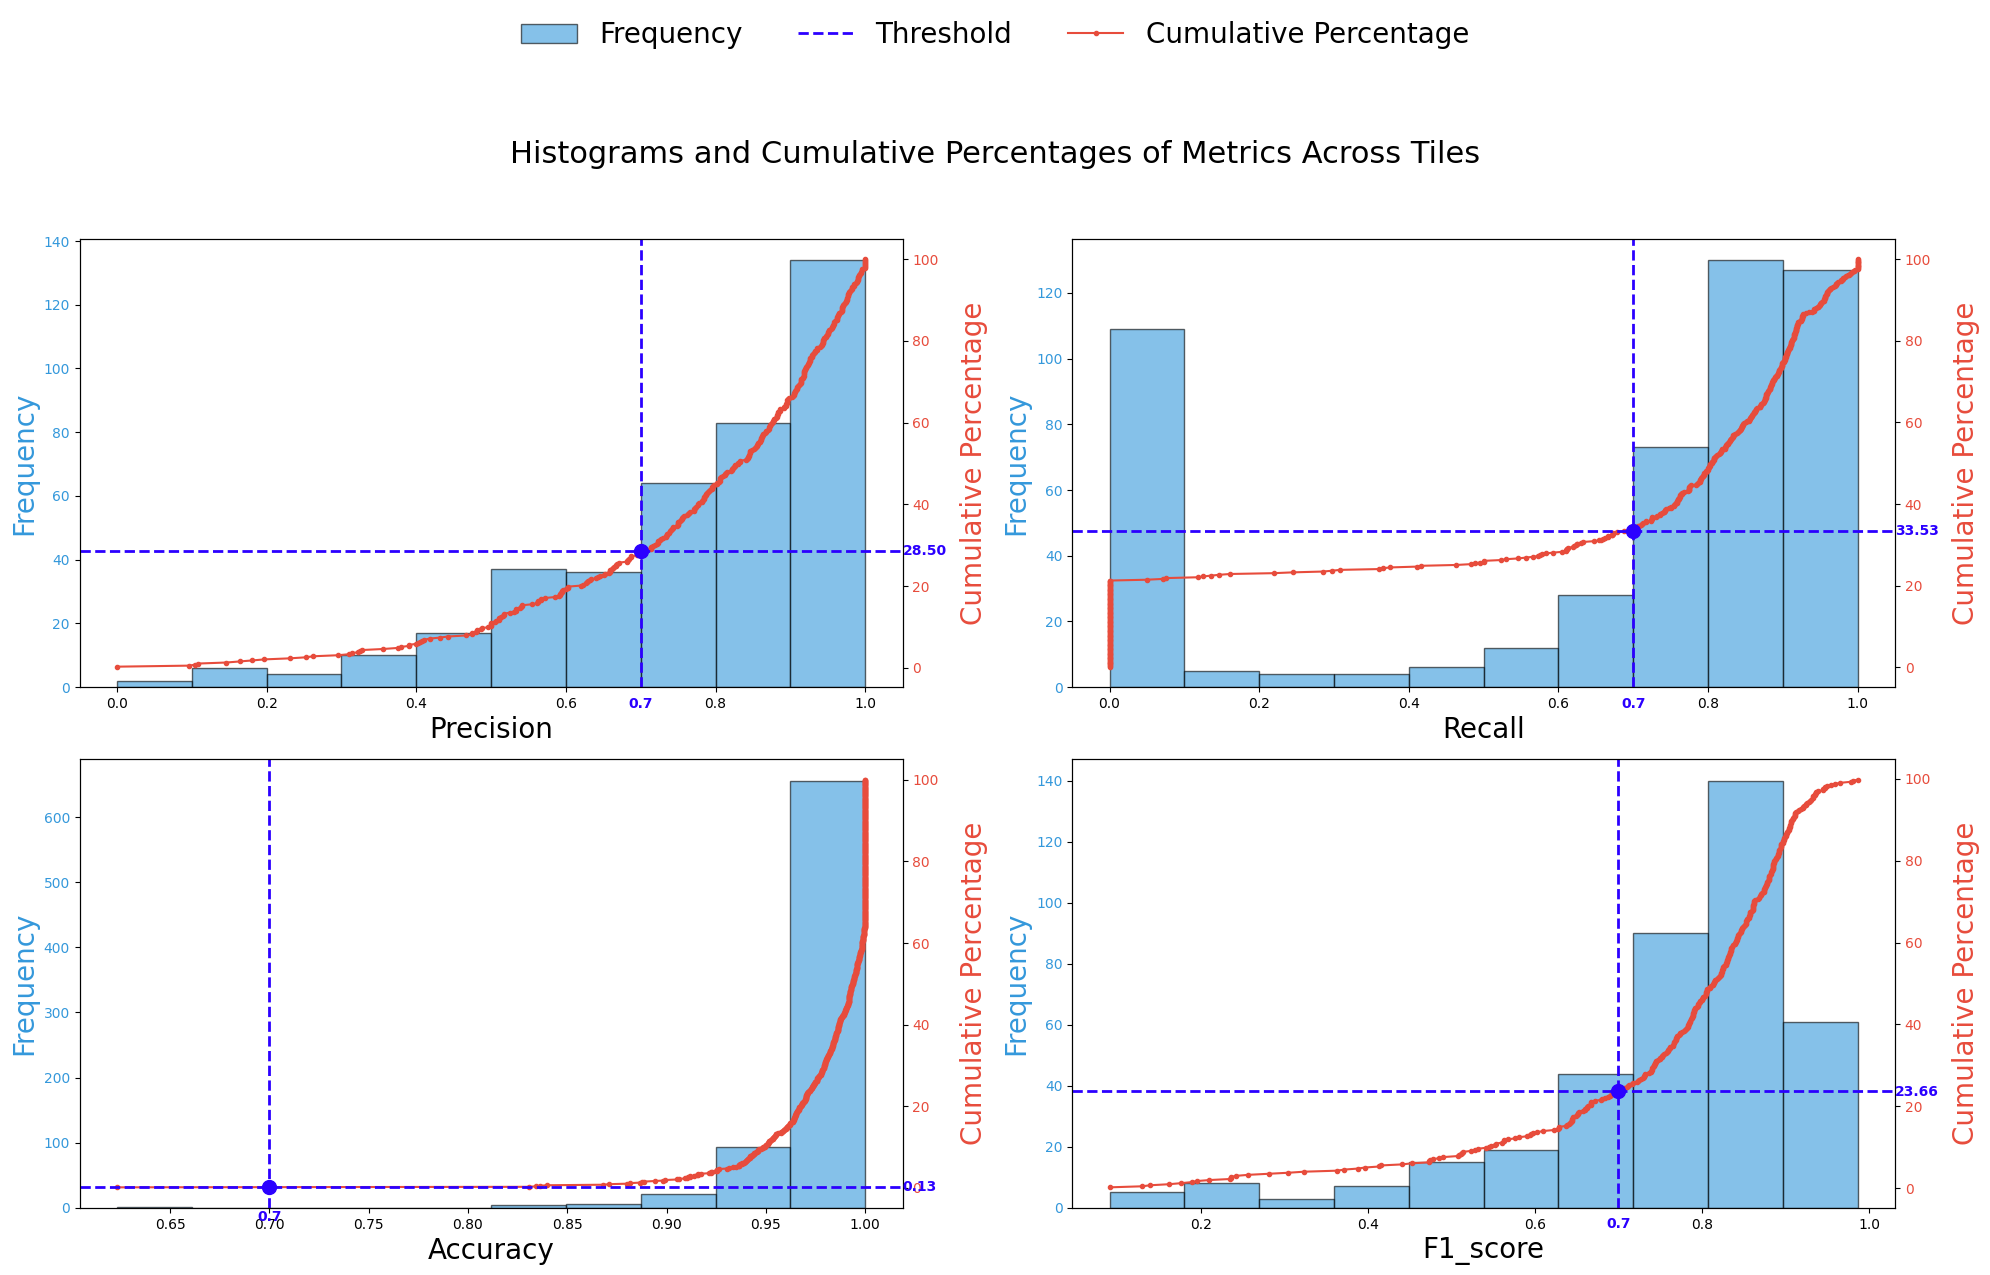

In [ ]:
print(f"Loading CNN model  ...")
model = load_model("/content/drive/MyDrive/HSI MODELS/best_rf_cnn_model_normalized.keras")
print("CNN model loaded successfully.")

def reshape_predictions(flat_predictions, tile_size):
    """
    Reshape flat predictions back to original tile shapes.
    """
    reshaped_predictions = []
    num_pixels = tile_size[0] * tile_size[1]
    for i in range(len(flat_predictions) // num_pixels):
        reshaped_predictions.append(
            flat_predictions[i * num_pixels: (i + 1) * num_pixels].reshape((tile_size[0], tile_size[1], 1))
        )
    return np.array(reshaped_predictions)


# --- Load RF Model and Make Predictions ---
def load_rf_and_predict(model_path, test_images, val_images, tile_size):
    """
    Load the RF model and use it to predict probabilities for the test and validation datasets.
    """
    print(f"Loading RF model from {model_path}...")
    rf = joblib.load(model_path)
    print("RF model loaded successfully.")

    # Flatten test and validation data
    print("Flattening test and validation data...")
    test_images_flattened = np.vstack([image.reshape(-1, image.shape[-1]) for image in test_images]).astype("float16")
    val_images_flattened = np.vstack([image.reshape(-1, image.shape[-1]) for image in val_images]).astype("float16")

    # Make predictions
    print("Making predictions with RF...")
    test_rf_probs = rf.predict_proba(test_images_flattened)[:, 1]
    val_rf_probs = rf.predict_proba(val_images_flattened)[:, 1]

    # Reshape predictions back to original tile sizes
    reshaped_test_rf = reshape_predictions(test_rf_probs, tile_size)
    reshaped_val_rf = reshape_predictions(val_rf_probs, tile_size)

    print("Predictions reshaped successfully.")
    return reshaped_test_rf, reshaped_val_rf


# Generate predictions and probabilities
def predict_cnn_tiles(model, test_images, threshold=0.5):
    """
    Predict probabilities and labels for each tile using a CNN model.
    Handle cases where probabilities are extreme.
    """
    y_proba_tiles = np.array([
        model.predict(tile[np.newaxis, ...]).flatten()
        for tile in test_images
    ])
    y_pred_tiles = (y_proba_tiles > threshold).astype(int)

    # Debugging: Check for extreme values
    print(f"Prediction probabilities - Min: {np.min(y_proba_tiles)}, Max: {np.max(y_proba_tiles)}")
    print(f"Unique predicted labels: {np.unique(y_pred_tiles)}")

    return y_pred_tiles, y_proba_tiles


# --- Identify Tiles with Zero Recall ---
def print_zero_recall_tiles(y_true_tiles, y_pred_tiles):
    """
    Print tiles with zero recall along with their GT and prediction maps.
    """
    print("\nIdentifying tiles with zero recall...")
    for i, (y_true_tile, y_pred_tile) in enumerate(zip(y_true_tiles, y_pred_tiles)):
        tp = np.sum((y_true_tile == 1) & (y_pred_tile == 1))  # True Positives
        fn = np.sum((y_true_tile == 1) & (y_pred_tile == 0))  # False Negatives

        recall = tp / (tp + fn) if (tp + fn) > 0 else 0

        if recall == 0:
            print(f"\nTile {i}: Zero Recall")

            # Ground Truth Label Map
            plt.imshow(y_true_tile.reshape((64, 64)), cmap="binary", vmin=0, vmax=1)
            plt.colorbar()
            plt.title(f"Tile {i} - Ground Truth (0: Water, 1: Oil)")
            plt.show()

            # Prediction Label Map
            plt.imshow(y_pred_tile.reshape((64, 64)), cmap="binary", vmin=0, vmax=1)
            plt.colorbar()
            plt.title(f"Tile {i} - Prediction (0: Water, 1: Oil)")
            plt.show()


# Load the RF model and make predictions
model_path = "/content/drive/MyDrive/HSI MODELS/random_forest_ PCA 32 - Normalized.pkl"
tile_size = (64, 64)
reshaped_test_rf, reshaped_val_rf = load_rf_and_predict(model_path, test_images, val_images, tile_size)

# Get predictions and probabilities
y_pred_tiles, y_proba_tiles = predict_cnn_tiles(model, reshaped_test_rf, threshold=0.5)


# Flatten true labels
y_true_tiles = np.array([label.flatten() for label in test_labels])

# Print tiles with zero recall
#print_zero_recall_tiles(y_true_tiles, y_pred_tiles)

# Generate evaluation report
evaluation_report(
    y_true_tiles=y_true_tiles,
    y_pred_tiles=y_pred_tiles,
    y_proba_tiles=y_proba_tiles,
    model_title="RF + CNN "
)

## 5. XGBoost


In [ ]:
XGB = load_model("/content/drive/MyDrive/HSI MODELS/xgboost_PCA 32 Normalized .pkl")

Loading model from /content/drive/MyDrive/HSI MODELS/xgboost_PCA 32 Normalized .pkl...
Model loaded successfully.


Flattening testing data...
Flattening image and label tiles...
Flattened 780 tiles.
Flattened test images shape: (3194880, 32)
Overall Metrics for XGB Model:
   Metric    Value
 Accuracy 0.979578
Precision 0.826356
   Recall 0.779974
 F1 Score 0.802495
      AUC 0.988285
Evaluating metrics per tile...
Tile 1/780: TP=254, TN=3239, FP=572, FN=31, Precision=0.3075060532687651, Recall=0.8912280701754386, Accuracy=0.8528, F1 Score=0.45724572457245727
Tile 2/780: TP=0, TN=3957, FP=0, FN=139, Precision=None, Recall=0.0, Accuracy=0.9661, F1 Score=None
Tile 3/780: TP=66, TN=3923, FP=105, FN=2, Precision=0.38596491228070173, Recall=0.9705882352941176, Accuracy=0.9739, F1 Score=0.5523012552301255
Tile 4/780: TP=242, TN=3760, FP=44, FN=50, Precision=0.8461538461538461, Recall=0.8287671232876712, Accuracy=0.9771, F1 Score=0.8373702422145328
Tile 5/780: TP=25, TN=4054, FP=13, FN=4, Precision=0.6578947368421053, Recall=0.8620689655172413, Accuracy=0.9958, F1 Score=0.746268656716418
Tile 6/780: TP=144

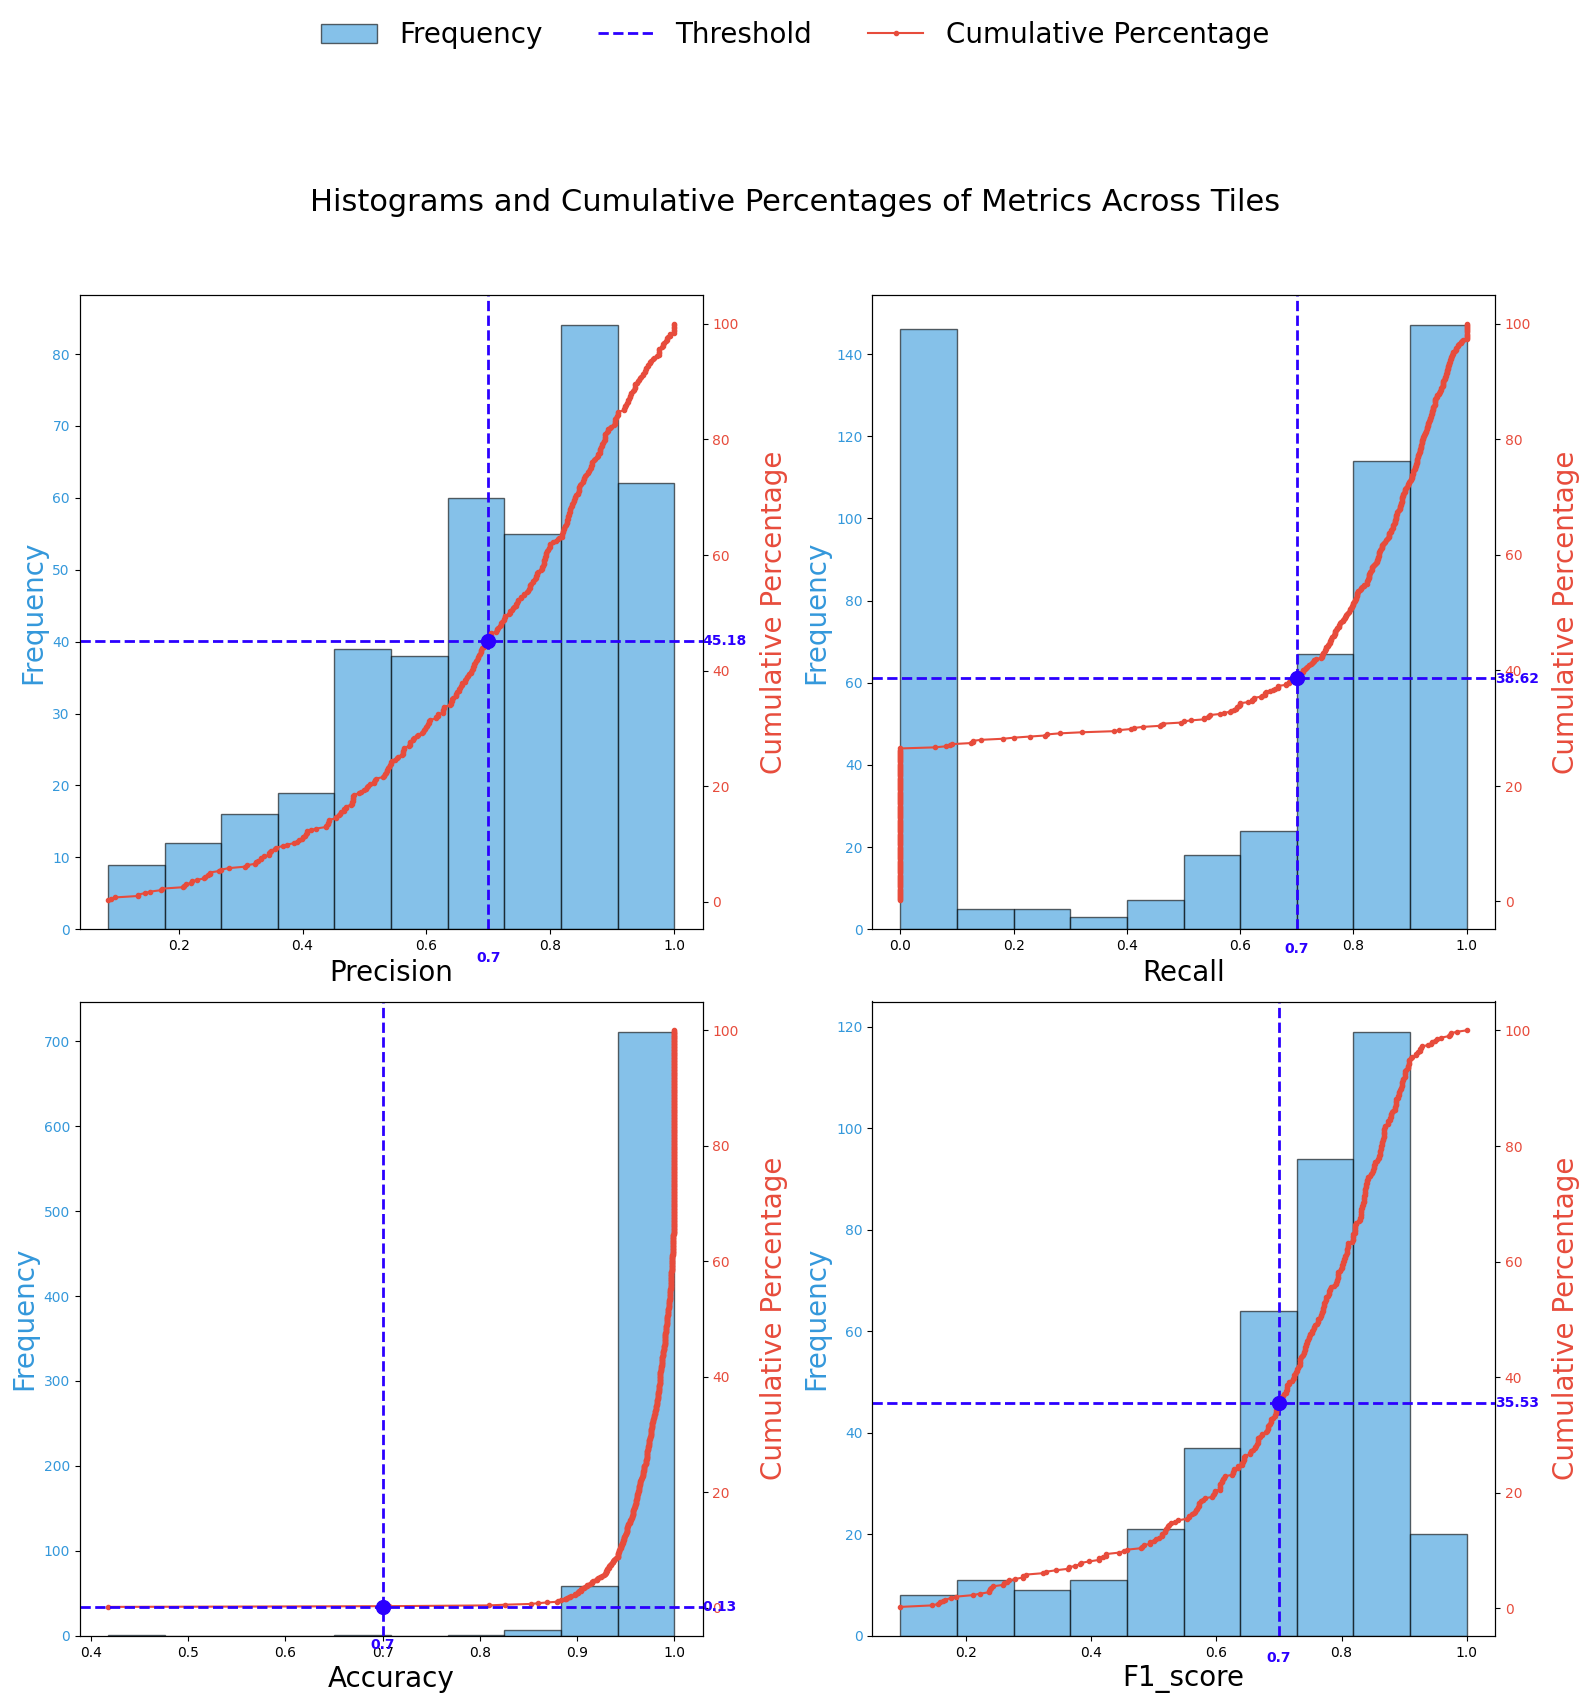

90514

In [ ]:
print("Flattening testing data...")

# Flatten the test images and labels
test_images_flattened, test_labels_flattened = flatten_tiles(test_images, test_labels)

# Ensure the flattened images are in the correct shape (n_samples, n_features)
test_images_flattened = test_images_flattened.reshape(
    test_images_flattened.shape[0], -1
)

print(f"Flattened test images shape: {test_images_flattened.shape}")

# Predict probabilities
predictions_proba = XGB.predict_proba(test_images_flattened)

# Convert probabilities to binary labels
predictions_labels = (predictions_proba[:, 1] > 0.5).astype(int)

# Reshape predictions back to the original tile shape
reshaped_predictions_proba = flat_prediction_to_tile_shape(predictions_proba[:, 1], test_labels)
reshaped_predictions_labels = flat_prediction_to_tile_shape(predictions_labels, test_labels)

# Evaluate and report metrics
evaluation_report(np.array(test_labels), np.array(reshaped_predictions_labels), np.array(reshaped_predictions_proba), "XGB")

gc.collect()

## 6. Attention based U-net

Loading model from /content/drive/MyDrive/HSI MODELS/best_Attention_UNET_model.keras...
Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━

<ipython-input-11-0411d222ea9b>:180: RuntimeWarning: invalid value encountered in scalar divide
  f1_score_tile = (2 * (precision * recall) / (precision + recall))


Tile 611/780: TP=59, TN=3866, FP=9, FN=162, Precision=0.8676470588235294, Recall=0.2669683257918552, Accuracy=0.9583, F1 Score=0.4083044982698962
Tile 612/780: TP=191, TN=3785, FP=11, FN=109, Precision=0.9455445544554455, Recall=0.6366666666666667, Accuracy=0.9707, F1 Score=0.7609561752988049
Tile 613/780: TP=0, TN=4096, FP=0, FN=0, Precision=None, Recall=None, Accuracy=1.0000, F1 Score=None
Tile 614/780: TP=2123, TN=1559, FP=288, FN=126, Precision=0.8805474906677727, Recall=0.9439751000444642, Accuracy=0.8989, F1 Score=0.9111587982832617
Tile 615/780: TP=0, TN=4096, FP=0, FN=0, Precision=None, Recall=None, Accuracy=1.0000, F1 Score=None
Tile 616/780: TP=0, TN=4096, FP=0, FN=0, Precision=None, Recall=None, Accuracy=1.0000, F1 Score=None
Tile 617/780: TP=184, TN=3785, FP=6, FN=121, Precision=0.968421052631579, Recall=0.6032786885245902, Accuracy=0.9690, F1 Score=0.7434343434343436
Tile 618/780: TP=609, TN=3180, FP=24, FN=283, Precision=0.9620853080568721, Recall=0.6827354260089686, Accu

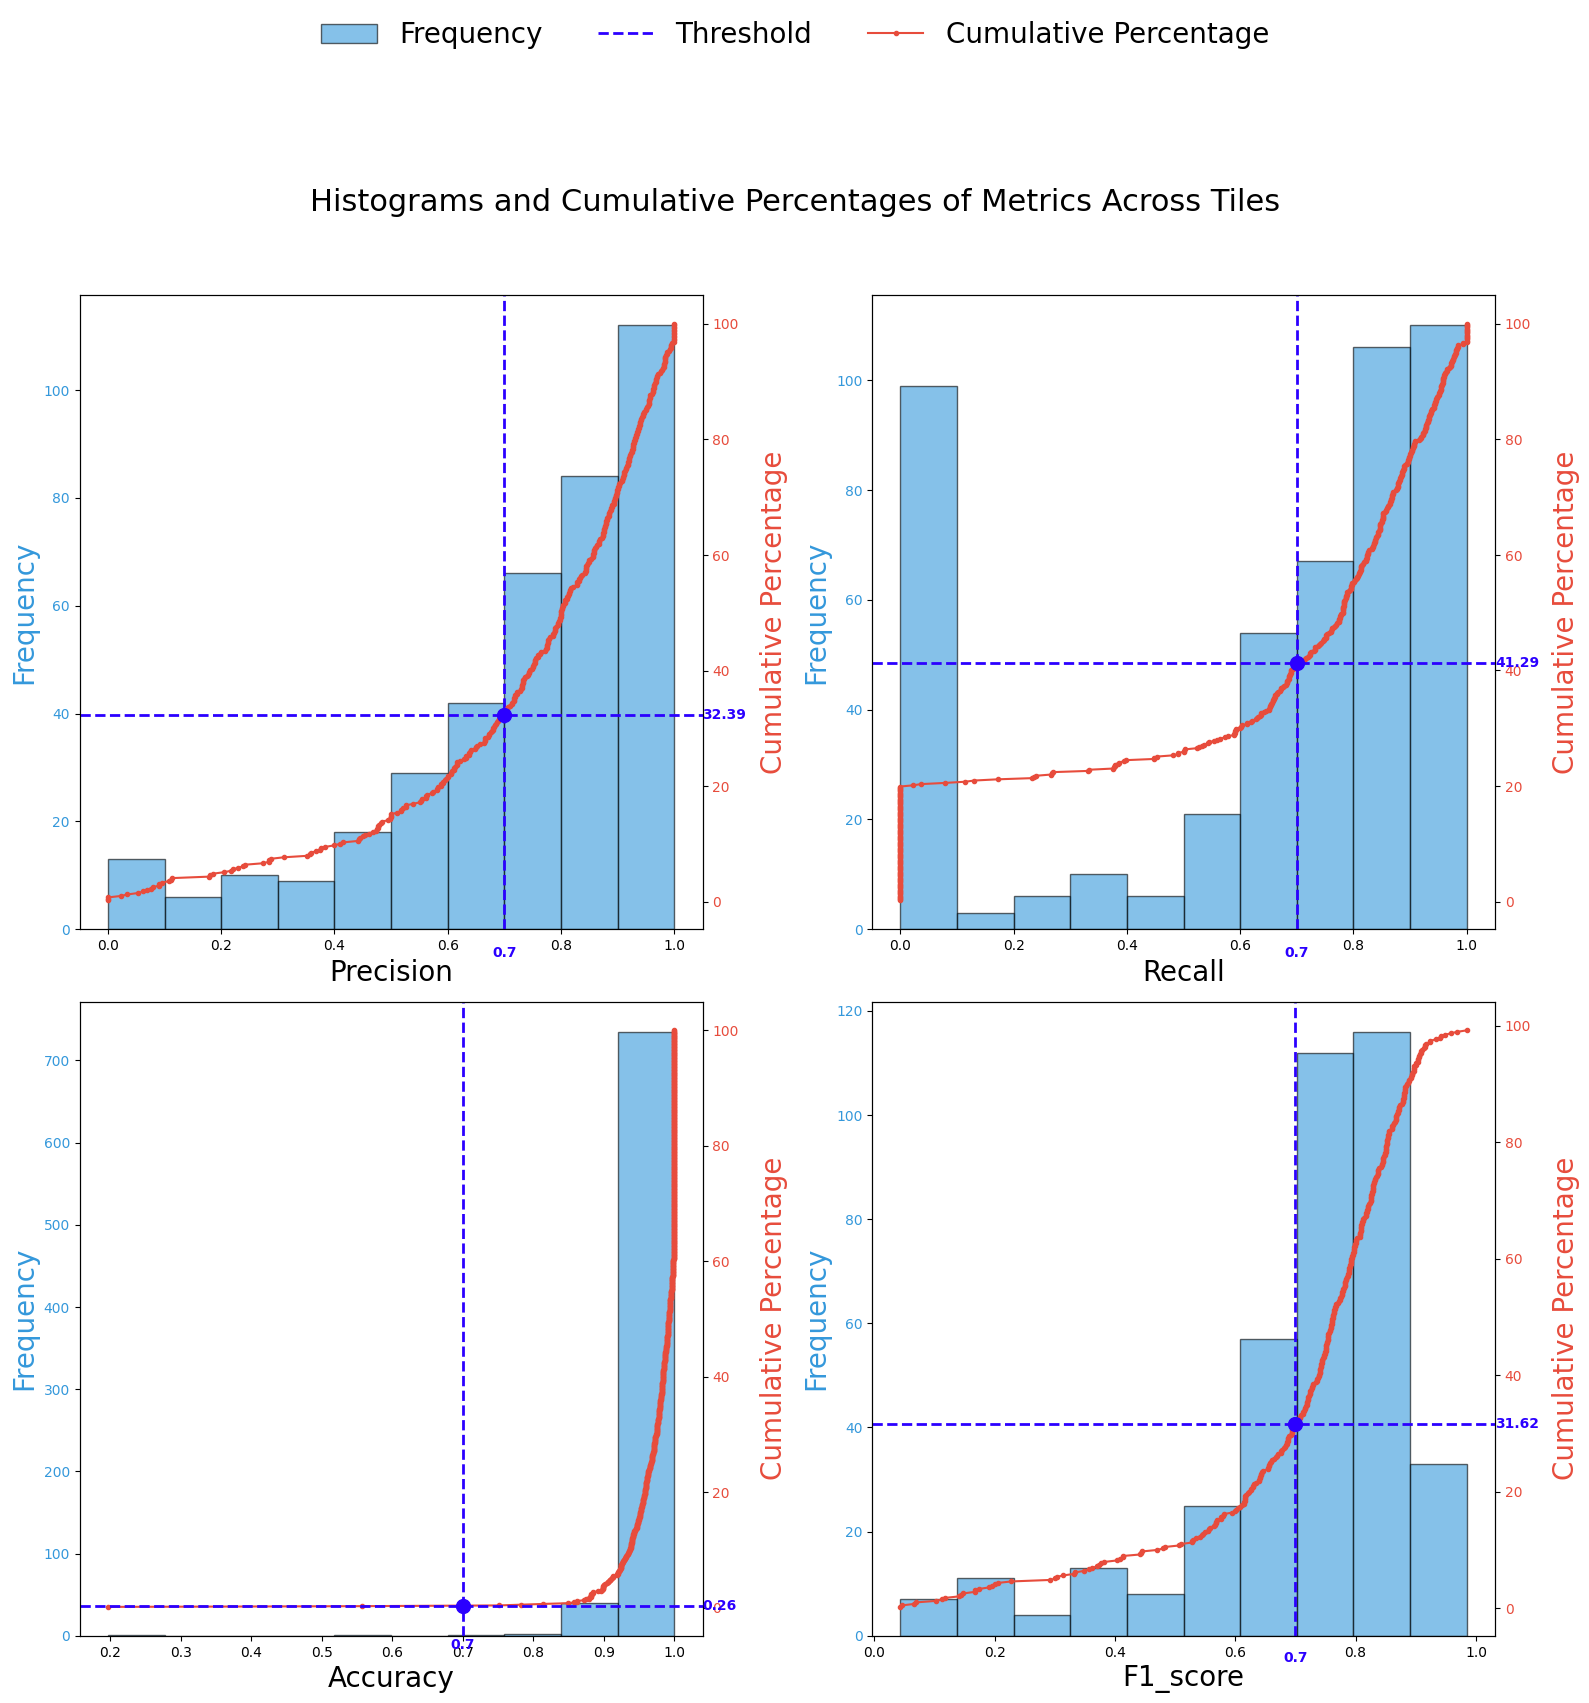

In [ ]:
# Example usage
# Load your trained U-Net model
model = load_model("/content/drive/MyDrive/HSI MODELS/best_Attention_UNET_model.keras")



# Get predictions and probabilities
y_pred_tiles, y_proba_tiles = predict_cnn_tiles(model, test_images, threshold=0.5)


# Flatten true labels
y_true_tiles = np.array([label.flatten() for label in test_labels])


# Generate evaluation report
evaluation_report(
    y_true_tiles=y_true_tiles,
    y_pred_tiles=y_pred_tiles,
    y_proba_tiles=y_proba_tiles,
    model_title="Unet"
)







## 7. Hybrid SN

Loading model from /content/drive/MyDrive/HSI MODELS/best_model_HybridSN.keras...
Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━

<ipython-input-11-0411d222ea9b>:180: RuntimeWarning: invalid value encountered in scalar divide
  f1_score_tile = (2 * (precision * recall) / (precision + recall))


Tile 607/780: TP=0, TN=4096, FP=0, FN=0, Precision=None, Recall=None, Accuracy=1.0000, F1 Score=None
Tile 608/780: TP=64, TN=3985, FP=34, FN=13, Precision=0.6530612244897959, Recall=0.8311688311688312, Accuracy=0.9885, F1 Score=0.7314285714285713
Tile 609/780: TP=0, TN=4096, FP=0, FN=0, Precision=None, Recall=None, Accuracy=1.0000, F1 Score=None
Tile 610/780: TP=1806, TN=1750, FP=38, FN=502, Precision=0.9793926247288504, Recall=0.7824956672443674, Accuracy=0.8682, F1 Score=0.869942196531792
Tile 611/780: TP=45, TN=3966, FP=23, FN=62, Precision=0.6617647058823529, Recall=0.4205607476635514, Accuracy=0.9792, F1 Score=0.5142857142857142
Tile 612/780: TP=185, TN=3865, FP=17, FN=29, Precision=0.9158415841584159, Recall=0.8644859813084113, Accuracy=0.9888, F1 Score=0.889423076923077
Tile 613/780: TP=0, TN=4096, FP=0, FN=0, Precision=None, Recall=None, Accuracy=1.0000, F1 Score=None
Tile 614/780: TP=2386, TN=1589, FP=25, FN=96, Precision=0.9896308585649108, Recall=0.9613215149073328, Accuracy

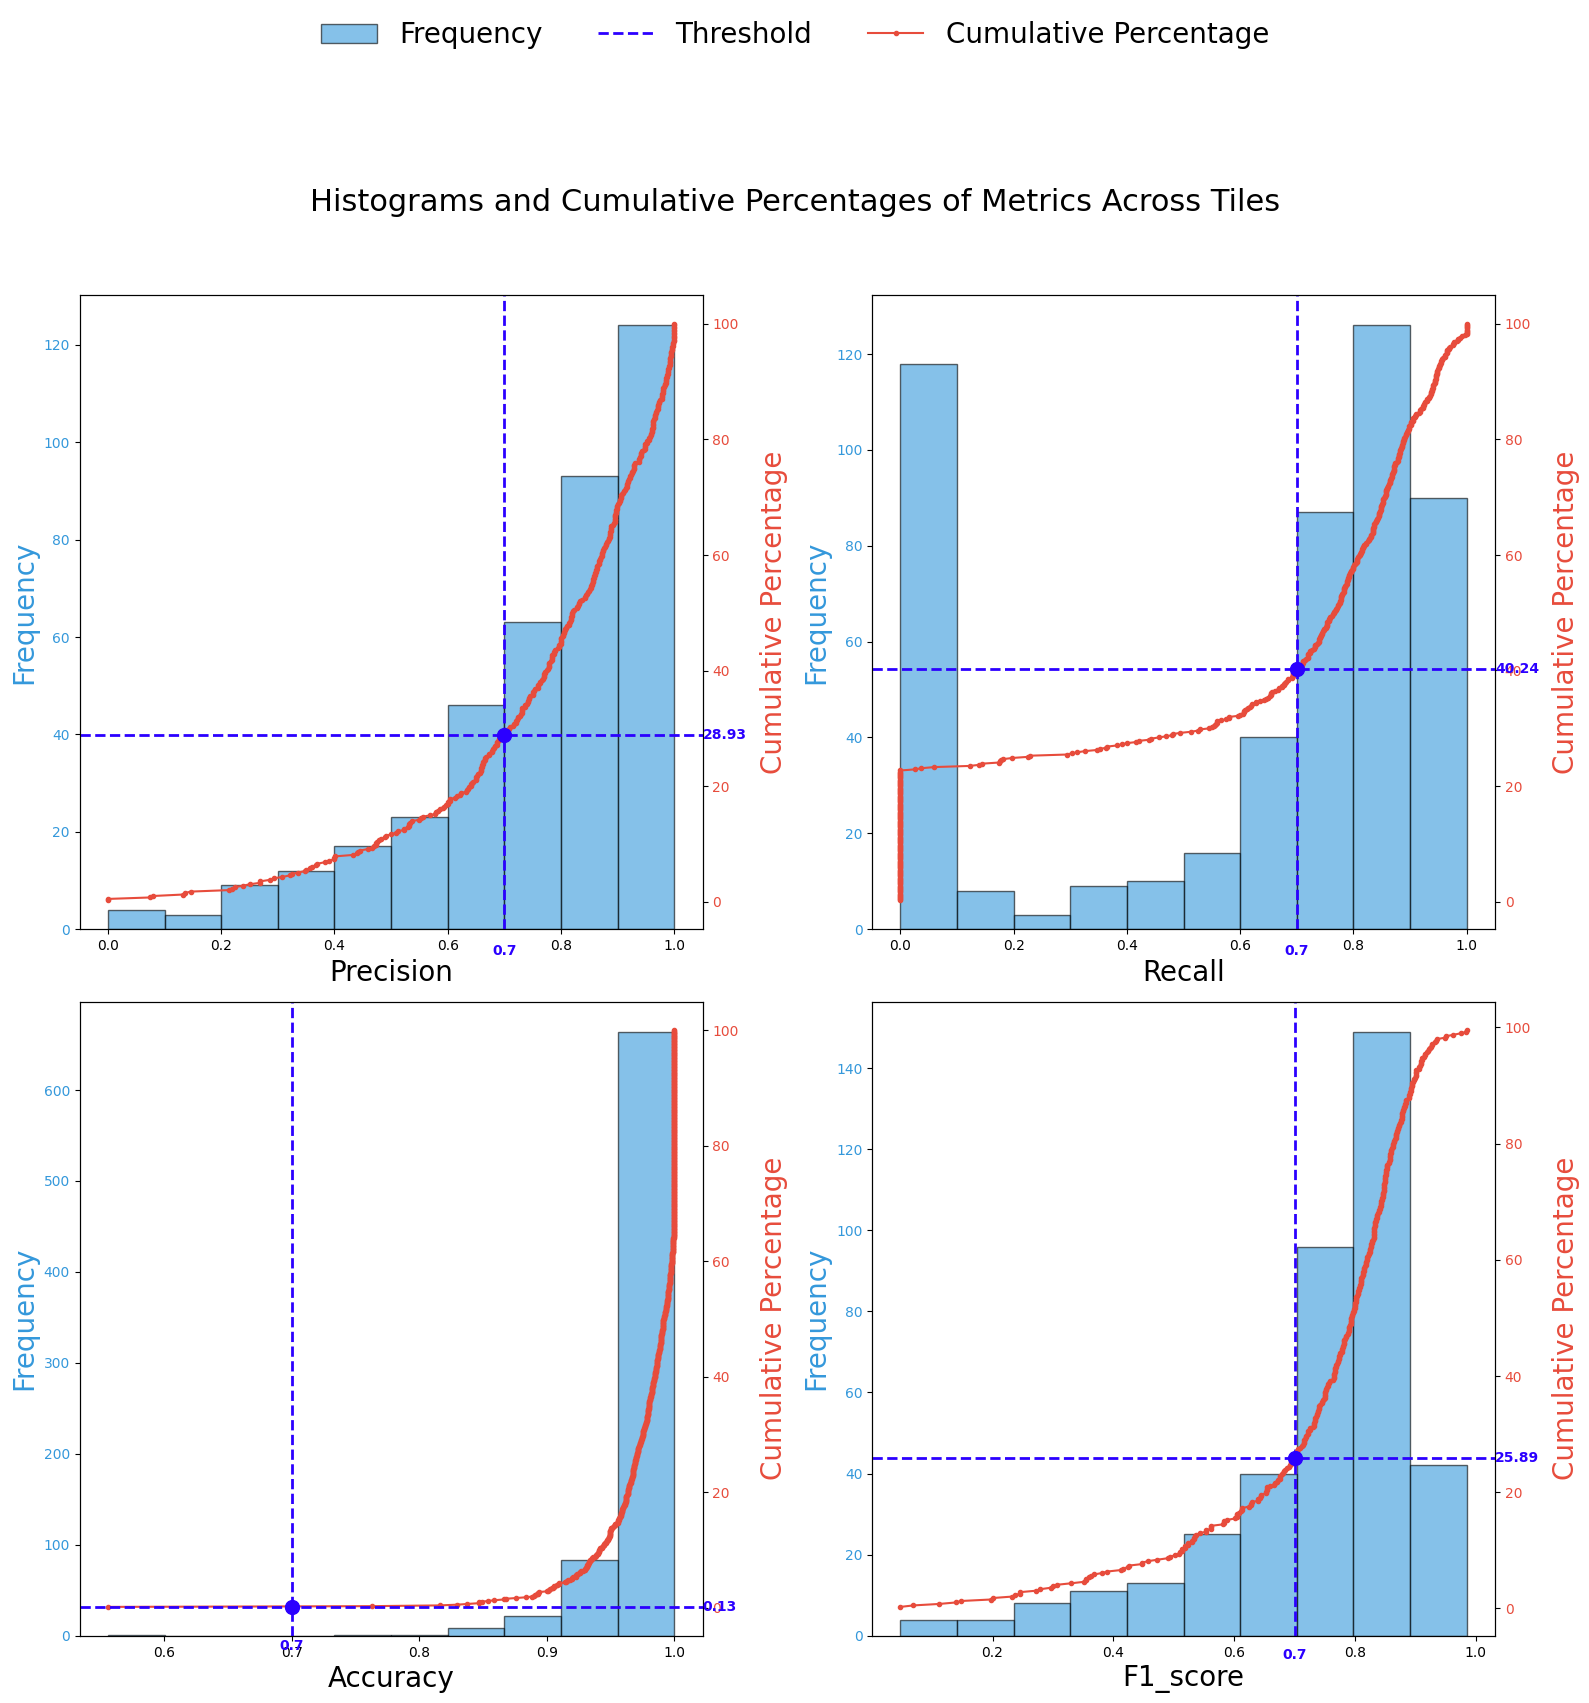

In [ ]:
# Example usage
# Load your trained U-Net model
model = load_model("/content/drive/MyDrive/HSI MODELS/best_model_HybridSN.keras")



# Get predictions and probabilities
y_pred_tiles, y_proba_tiles = predict_cnn_tiles(model, test_images, threshold=0.5)


# Flatten true labels
y_true_tiles = np.array([label.flatten() for label in test_labels])


# Generate evaluation report
evaluation_report(
    y_true_tiles=y_true_tiles,
    y_pred_tiles=y_pred_tiles,
    y_proba_tiles=y_proba_tiles,
    model_title="HybridSN"
)







Evaluating overall metrics...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━

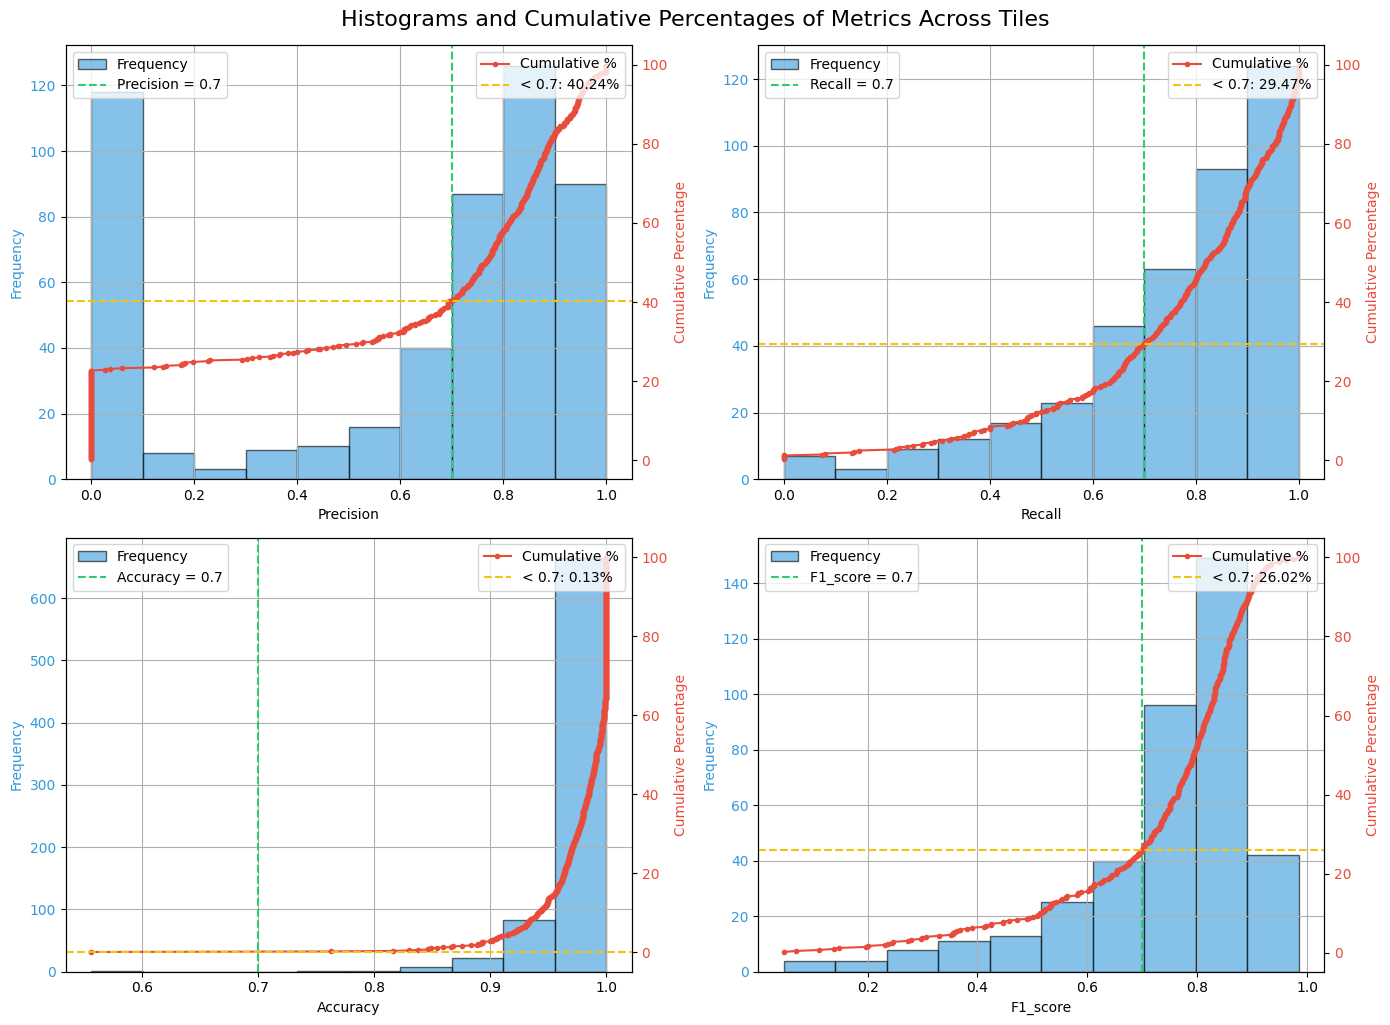

In [ ]:


# --- Utility Functions ---
def flatten_tiles(images, labels):
    """
    Flatten image and label tiles into a 2D array and a 1D array, respectively.
    """
    flattened_images = [image.reshape(-1, image.shape[-1]) for image in images]
    flattened_labels = [label.flatten() for label in labels]
    return flattened_images, flattened_labels


def evaluate_overall_unet(model, test_images, test_labels):
    """
    Evaluate overall metrics for a U-Net model on the entire test set.
    """
    print("Evaluating overall metrics...")
    y_true = np.hstack([label.flatten() for label in test_labels])
    y_pred = np.hstack([
        model.predict(tile[np.newaxis, ...]).round().flatten()
        for tile in test_images
    ])
    y_proba = np.hstack([
        model.predict(tile[np.newaxis, ...]).flatten()
        for tile in test_images
    ])

    # Compute overall metrics
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba)

    metrics = {
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "AUC": auc,
    }

    print("\nOverall Metrics:")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")

    return metrics


def evaluate_metrics_per_tile_unet(model, test_images, test_labels):
    """
    Evaluate metrics per tile for a U-Net model.
    """
    metrics_per_tile = []

    print("Evaluating metrics per tile...")
    for i, (tile_image, tile_label) in enumerate(zip(test_images, test_labels)):
        y_true_tile = tile_label.flatten()
        y_pred_tile = model.predict(tile_image[np.newaxis, ...]).round().flatten()
        y_proba_tile = model.predict(tile_image[np.newaxis, ...]).flatten()

        # Calculate metrics
        tp = np.sum((y_true_tile == 1) & (y_pred_tile == 1))  # True Positives
        tn = np.sum((y_true_tile == 0) & (y_pred_tile == 0))  # True Negatives
        fp = np.sum((y_true_tile == 0) & (y_pred_tile == 1))  # False Positives
        fn = np.sum((y_true_tile == 1) & (y_pred_tile == 0))  # False Negatives

        precision = tp / (tp + fp) if (tp + fp) > 0 else None
        recall = tp / (tp + fn) if (tp + fn) > 0 else None
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        f1_score_tile = 2 * (precision * recall) / (precision + recall) if (precision and recall) else None

        metrics_per_tile.append({
            "precision": precision,
            "recall": recall,
            "accuracy": accuracy,
            "f1_score": f1_score_tile,
        })

    return metrics_per_tile


def plot_histograms_with_cumulative_unet(metrics_per_tile):
    """
    Plot histograms and cumulative percentages for evaluation metrics across tiles.
    """
    print("Plotting histograms and cumulative percentages...")
    metrics = ["precision", "recall", "accuracy", "f1_score"]
    threshold = 0.7  # Threshold for metrics

    # Extract values for each metric
    stability_metrics = {
        metric: {
            "values": np.sort([m[metric] for m in metrics_per_tile if m[metric] is not None])
        }
        for metric in metrics
    }

    # Plot histograms and cumulative percentages
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, (metric, stats) in enumerate(stability_metrics.items()):
        values = stats["values"]
        cumulative_percentage = np.arange(1, len(values) + 1) / len(values) * 100

        ax1 = axes[idx]
        ax2 = ax1.twinx()

        # Plot histogram
        ax1.hist(values, bins=10, alpha=0.6, color="#3498db", edgecolor="black", label="Frequency")
        ax1.set_xlabel(metric.capitalize())
        ax1.set_ylabel("Frequency", color="#3498db")
        ax1.tick_params(axis='y', labelcolor="#3498db")

        # Plot cumulative percentage
        ax2.plot(values, cumulative_percentage, color="#e74c3c", linestyle="-", marker=".", label="Cumulative %")
        ax2.set_ylabel("Cumulative Percentage", color="#e74c3c")
        ax2.tick_params(axis='y', labelcolor="#e74c3c")

        # Mark the threshold
        below_threshold = np.sum(values < threshold) / len(values) * 100
        ax1.axvline(x=threshold, color='#2ecc71', linestyle='--', label=f'{metric.capitalize()} = 0.7')
        ax2.axhline(y=below_threshold, color='#f1c40f', linestyle='--', label=f'< 0.7: {below_threshold:.2f}%')

        # Legends and grid
        ax1.legend(loc="upper left")
        ax2.legend(loc="upper right")
        ax1.grid()

    plt.tight_layout()
    plt.suptitle("Histograms and Cumulative Percentages of Metrics Across Tiles", fontsize=16, y=1.02)
    plt.show()


# --- Main Function ---
def evaluate_unet_with_both(model, test_images, test_labels):
    """
    Evaluate a U-Net model both overall and per tile.
    """
    # Overall evaluation
    overall_metrics = evaluate_overall_unet(model, test_images, test_labels)

    # Per-tile evaluation
    metrics_per_tile = evaluate_metrics_per_tile_unet(model, test_images, test_labels)

    # Plot histograms and cumulative percentages
    plot_histograms_with_cumulative_unet(metrics_per_tile)

    return overall_metrics, metrics_per_tile


# Example usage
# Load your trained U-Net model
unet_model = tf.keras.models.load_model("/content/drive/MyDrive/HSI MODELS/best_model_HybridSN.keras")

# Evaluate the U-Net model
overall_metrics, metrics_per_tile = evaluate_unet_with_both(unet_model, test_images, test_labels)

# 8.Comparison

In [ ]:
# Create a DataFrame from model_metrics
df = pd.DataFrame.from_dict(model_metrics, orient="index", columns=["Accuracy", "Precision", "Recall", "F1", "AUC"])
df.index.name = "Model Name"

# Create a Plotly table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=["Model Name", "Accuracy", "Precision", "Recall", "F1", "AUC"],
        fill_color="paleturquoise",
        align="left",
        font=dict(size=12, color="black"),
    ),
    cells=dict(
        values=[
            df.index,  # Model names
            df["Accuracy"],
            df["Precision"],
            df["Recall"],
            df["F1"],
            df["AUC"],
        ],
        fill_color="lavender",
        align="left",
        font=dict(size=12, color="black"),
    )
)])

# Show the table
fig.show()